C:\Users\arubi\AppData\Local\Temp\ipykernel_19404\692169099.py:18: RuntimeWarning: divide by zero encountered in log10
  return  -4.7752*np.log10(x)**3 + 11.19*np.log10(x)**2 - 20.836*np.log10(x)+33.222
C:\Users\arubi\AppData\Local\Temp\ipykernel_19404\692169099.py:18: RuntimeWarning: invalid value encountered in log10
  return  -4.7752*np.log10(x)**3 + 11.19*np.log10(x)**2 - 20.836*np.log10(x)+33.222


Text(0, 0.5, '$\\rm Shock~Speed~(km/s)$')

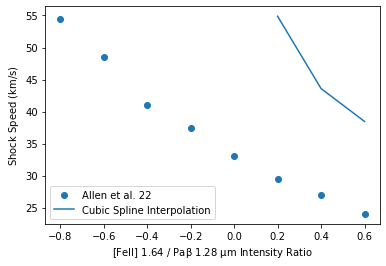

In [1]:
#the purpose here is to determine shock speeds from an interpolating function
#this works b/c MAPPINGS 5 models can output line spectra, and you can find a correspondence between that model line ratio 
#and some physical parameter. 
#with this, we can determine our line ratios and fine what physical parameters that leads to, narrowing param space

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
import sys

#input data used for interpolating functions
log_164_128 = [0.6,0.4,0.2,0,-0.2,-0.4,-0.6,-0.8][::-1]
unlog_ratio = [10**i for i in log_164_128]
shock_speed = [24,27,29.5,33,37.4,41,48.5,54.5][::-1]

#interpolation, by dan m watson from nomograms w/ MAPPINGS 5
def f_speed_164_128(x):
    return  -4.7752*np.log10(x)**3 + 11.19*np.log10(x)**2 - 20.836*np.log10(x)+33.222
f = CubicSpline(unlog_ratio, shock_speed)

#plotting
plt.scatter(log_164_128, shock_speed, label='Allen et al. 22') #the data from here?
plt.plot(log_164_128, f_speed_164_128(log_164_128), label='Cubic Spline Interpolation') #Dan's works!
plt.legend(loc='best')
plt.xlabel(r'$\rm [FeII]~1.64~/~Pa \beta~1.28~\mu m~Intensity~Ratio$')
plt.ylabel(r'$\rm Shock~Speed~(km/s)$')

In [2]:
#interpolation, by dan m watson from nomograms w/ MAPPINGS 5
def f_speed_126_128(x):
    return   -12.617*np.log10(x)**3 + 26.669*np.log10(x)**2 - 30.684*np.log10(x)+42.044
f = CubicSpline(unlog_ratio, shock_speed)

In [3]:
#loading in images
import glob
from astropy.io import fits

#paths to our data
path_list = '../continuum_subtract/nocont*'
file_list = [i.replace('\\', '/') for i in glob.glob(path_list)]
print(file_list)

#opening data and headers
hdu_list = [fits.open(i) for i in file_list]
hdu_data_list = []
noise = [1.55e-18] * len(file_list)
for i in range(len(hdu_list)): 
    hdu_data = hdu_list[i][0].data
    hdu_data[hdu_data > 1e-14] = 0
    hdu_data[hdu_data < 1 * noise[i]] = 0
    hdu_data_list.append(hdu_data)
hdu_header_list = [i[0].header for i in hdu_list]
print([i.shape for i in hdu_data_list])

#using av uncertainty for cutoffs...
path = '../av_extinctions/deext_flam_Av_0.547_uncert.fits'
av_uncert_fits = fits.open(path)
av_uncert_data = av_uncert_fits[0].data

['../continuum_subtract/nocont_hdu0_hdu0_flam_126n_thresh100_cw3.5_combined_drz.fits', '../continuum_subtract/nocont_hdu0_hdu0_flam_128n_thresh100_cw3.5_combined_drz.fits', '../continuum_subtract/nocont_hdu0_hdu0_flam_164n_thresh100_cw3.5_combined_drz.fits']
[(2874, 2740), (2874, 2740), (2874, 2740)]


In [4]:
from astropy.io import fits

#a new fits file to be saved and viewed in DS9
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''
    
    #in case you have weird headers, you can do this
    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
#     if [badkey for badkey in wcs_header if badkey == 'ORGNAME'] == []:
#         hdu_new = fits.PrimaryHDU(array, header=wcs_header)
#     else:
#         wcs_header = wcs_header.remove('ORGNAME')
#         hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    
    #creating a new fits file
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)     
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

In [29]:
#options are cutout2D from astropy or photutils apertures (my preference)
# https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord, FK5, ICRS
from astropy.wcs import WCS
from photutils.aperture import EllipticalAperture

#known pixel size
hst_pixsize = 0.12825 #arcsec

#reading in the .reg files made using DS9 
f1 = open('../measurements_by_hand/epoch2_361c_byhand_ellipses_ordered.reg', 'r')
file1_output = []
file2_output = []

#looping through files
for line in f1:
    file1_output.append(line)
f1.close()

#fix file contents
#contents are ra, dec, width, height, rotation
file1_output = [i[8:-2] for i in file1_output[3:]]

#next step is for image, loop through all regions and make a list of region properties
sq_ra_diff_list = []
sq_dec_diff_list = []
sq_ra_pix_list = []
sq_dec_pix_list = []
side_a_list = []
side_b_list = []
sq_rotation_list = []

#coordinate details very much compacted (likely better ways to do this)
split_params1 = [i.split(',') for i in file1_output]
ra_hms_list = [(ra1[0].split(':')[0]+'h' + ra1[0].split(':')[1]+'m' + ra1[0].split(':')[2]+'s') for ra1 in split_params1]
dec_dms_list = [(dec1[1].split(':')[0]+'d' + dec1[1].split(':')[1]+'m' + dec1[1].split(':')[2]+'s') for dec1 in split_params1]

#offsets that can be used for finding knot offsets between epochs
pos_list = [SkyCoord(ra+' '+dec, frame=FK5, unit=(u.hourangle, u.deg)) for ra, dec in zip(ra_hms_list, dec_dms_list)] #this is all in degrees, what a lie...units are input units

#this isn't working for some reason...skycoord_to_pixel doesn't seem to like the units? not sure
ra_pix_list = [skycoord_to_pixel(i, wcs=WCS(hdu_header_list[0]))[0] for i in pos_list]
dec_pix_list = [skycoord_to_pixel(i, wcs=WCS(hdu_header_list[0]))[1] for i in pos_list]

#aperture size details in pixels (?)
rad_a_list = [1./hst_pixsize * float(a1[2][:-1]) for a1 in split_params1]
rad_b_list = [1./hst_pixsize * float(b1[3][:-1]) for b1 in split_params1]
rotation_list = [float(rot1[4]) for rot1 in split_params1]

# #making apertures
aperture_list = []
aper_mask_list = []
for i in range(len(ra_pix_list)):
    aperture_list.append(EllipticalAperture([ra_pix_list[i], dec_pix_list[i]], 
                                       rad_a_list[i], rad_b_list[i], theta=rotation_list[i]))
    aper_mask_list.append(aperture_list[i].to_mask())

C:\Users\arubi\AppData\Local\Temp\ipykernel_19404\222343130.py:33: RuntimeWarning: divide by zero encountered in true_divide
  ratio_data = hdu_data_list[0] / hdu_data_list[1] #1.26 / 1.28 micron ratio
C:\Users\arubi\AppData\Local\Temp\ipykernel_19404\222343130.py:33: RuntimeWarning: invalid value encountered in true_divide
  ratio_data = hdu_data_list[0] / hdu_data_list[1] #1.26 / 1.28 micron ratio
C:\Users\arubi\AppData\Local\Temp\ipykernel_19404\222343130.py:34: RuntimeWarning: divide by zero encountered in log10
  vshock_img_interp = np.nan_to_num(f_speed_126_128(np.log10(ratio_data))) #omitting nan values
C:\Users\arubi\AppData\Local\Temp\ipykernel_19404\2177388670.py:3: RuntimeWarning: invalid value encountered in log10
  return   -12.617*np.log10(x)**3 + 26.669*np.log10(x)**2 - 30.684*np.log10(x)+42.044
C:\Users\arubi\AppData\Local\Temp\ipykernel_19404\2177388670.py:3: RuntimeWarning: invalid value encountered in add
  return   -12.617*np.log10(x)**3 + 26.669*np.log10(x)**2 - 30

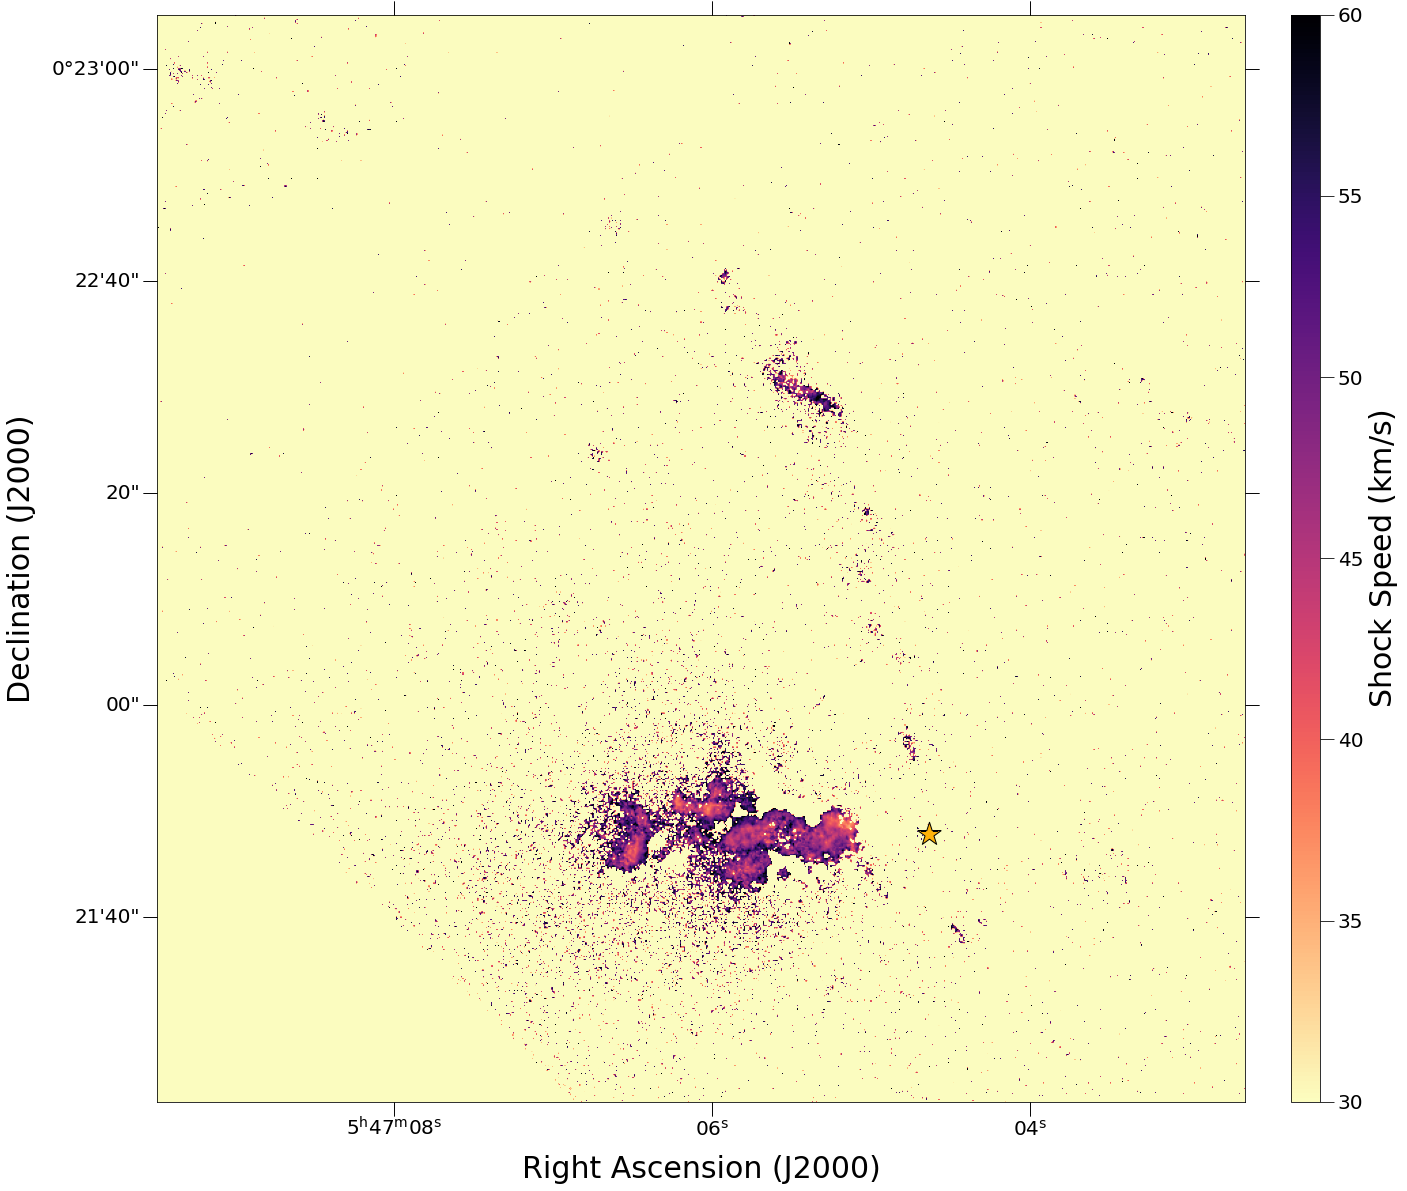

In [30]:
#plotting resulting image
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.ticker
                
#formatting for tick size
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#coordinates for IRS or HOPS objects
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s',\
            '5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s', '5h47m5.819s', '05h47m4.004s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', \
            '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s', '+00d22m37.45s', '+00d22m10.38s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]

coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(hdu_header_list[0])))

#creating figure
fig, ax = plt.subplots(figsize=(20, 20))
wcs = WCS(hdu_header_list[0])
ax = plt.subplot(projection=wcs) #projection for ra/dec coords

#saving data
ratio_data = hdu_data_list[0] / hdu_data_list[1] #1.26 / 1.28 micron ratio
vshock_img_interp = np.nan_to_num(f_speed_126_128(np.log10(ratio_data))) #omitting nan values
vshock_img_interp[vshock_img_interp < 28] = 0
vshock_img_interp[vshock_img_interp > 62] = 0
speed_path = fits_saver(ratio_data, hdu_header_list[0], 'f126n_f128n_ratio.fits', '')
speed_path = fits_saver(vshock_img_interp, hdu_header_list[0], 'mappings_shock_speed.fits', '')

#plotting
interval = ZScaleInterval()
data_interval = interval.get_limits(vshock_img_interp)
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1]) #automatic scaling
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=20., vmax=80) #redone in ds9
im = ax.imshow(vshock_img_interp, vmin=30, vmax=60, origin='lower', cmap='magma_r') #feel free to choose your favorite cmap
hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='xkcd:saffron', marker='*', \
                           edgecolor='black', s=600) for c_pair in coord_pix_list[2:3]] #to plot hops sources


#plotting ellipses instead of contours
from matplotlib.patches import Ellipse
for i in range(len(ra_pix_list)):
    ellipse = Ellipse((ra_pix_list[i], dec_pix_list[i]), rad_a_list[i], rad_b_list[i], rotation_list[i], \
                     color='lightblue', fc='None', lw=1)
#     ax.add_patch(ellipse)

#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Shock~Speed~(km/s)$', size=30)
cbar.ax.tick_params(labelsize=20)

#general formatting
ax.set_xlim(700, 1500)
ax.set_ylim(1050, 1850)
# ax.coords.grid(True, color='white', ls='solid', linewidth=0.75)
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)
ax.coords[0].set_minor_frequency(1) #for minor ticks
ax.coords[1].set_minor_frequency(1)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', which='minor', length=10)
ax.tick_params(axis='y', which='minor', length=10)
# ax.invert_yaxis() #done because it's nicer, with declination increasing
# ax.invert_xaxis() #done because it's nicer with ra decreasing

#adding a compass
# theta_wcs = (135+180+27)*np.pi/180 #the angle may not be exactly right
# x, y, arrow_length = 0.87, 0.59, 0.1 #this should be chnaged
# compass_N = ax.annotate('N', xy=(x, y), xytext=(x-arrow_length*1/1.5*np.sin(theta_wcs+np.pi/3.), \
#             y+arrow_length*2.9/2*np.cos(theta_wcs+np.pi/3.)), 
#             arrowprops=dict(arrowstyle='<-', lw=3, color='black'), color='black',
#             ha='center', va='center', fontsize=25, rotation=46,
#             xycoords='subfigure fraction') #ax.transAxes)
# compass_E = ax.annotate('E', xy=(x, y), xytext=(x-arrow_length*8/8*np.cos(theta_wcs+np.pi/2.), \
#             y-arrow_length*10/12*np.sin(theta_wcs+np.pi/2.)), 
#             arrowprops=dict(arrowstyle='<-', lw=3, color='black'), color='black',
#             ha='center', va='center', fontsize=25, rotation=46,
#             xycoords='subfigure fraction') #ax.transAxes)

plt.savefig('shock_speed_mappings.png', dpi=300, bbox_inches='tight')
plt.savefig('shock_speed_mappings.pdf', dpi=300, bbox_inches='tight')